In [135]:
import os
import bq_helper
import geopandas
import folium

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
import numpy as np

from bq_helper import BigQueryHelper
from geopandas import GeoDataFrame
from matplotlib.lines import Line2D
from sklearn import linear_model
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

In [2]:
#folder location
dir = 'C:/Users/Yang Yue/Documents/GitHub/ACE_592_Project/'

# Part 1: Preparation

## 1.1. Housing Data

In [3]:
#read the chicago housing price data
df_house = pd.read_csv(dir+'Zillow Neighborhood Housing Price.csv')
df_house_chicago = df_house.loc[df_house['City']=='Chicago']

#read the 2010 chicago census data and 
df_commu = pd.read_csv(dir+'Chicago 2010 Census.csv')
df_commu = df_commu[['Geog','GeogKey']]
df_commu = df_commu.rename(columns={'Geog':'community_area','GeogKey':'community_area_code'})

In [4]:
#create a dictonary that maps community area code to community area full name
dict_commu = pd.Series(df_commu.community_area.values,index=df_commu.community_area_code).to_dict()

In [5]:
#clean the chicago housing price data
#get rid of unusable community_areas
list_commu = list(dict_commu.values())
df_house_chicago['in_community_list'] = df_house_chicago['RegionName'].apply(lambda x: x in list_commu)
df_house_chicago = df_house_chicago[df_house_chicago['in_community_list']==True]

#get rid of irrelevant columns
list_labels_to_drop = ['RegionID','SizeRank','RegionType','StateName','State','City','Metro','CountyName','in_community_list']
df_house_chicago = df_house_chicago.drop(list_labels_to_drop,axis=1)
df_house_chicago = df_house_chicago.drop(df_house_chicago.columns[1:61],axis=1)

#reformat time label
list_time_labels = df_house_chicago.columns[1:].tolist()
list_labels_update = ['community_area']
for i in list_time_labels:
    list_labels_update.append(i[:-3])
df_house_chicago.columns = list_labels_update

#drop missing values
df_house_chicago = df_house_chicago.dropna()

df_house_chicago = df_house_chicago.sort_values('community_area')

In [7]:
#reformat the dataframe, group by community area, month
df_house_chicago_reindex = df_house_chicago.melt(id_vars=['community_area'],var_name='month',value_name='price')
df_house_chicago_reindex = df_house_chicago_reindex.set_index(['community_area','month'])
df_house_chicago_reindex = df_house_chicago_reindex.sort_values(by=['community_area','month'])

In [8]:
#create a list of community area in the housing dataframe, after dropping unusable data
list_relevant_commu = df_house_chicago['community_area'].tolist()

## 1.2. Population Data

In [9]:
#read the 2010 chicago census data
df_pop = pd.read_csv(dir+'Chicago 2010 Census.csv')
df_pop = df_pop[['GeogKey','Total Population']]
df_pop = df_pop.rename(columns={'GeogKey':'community_area_code','Total Population':'population'})

In [10]:
#create a dictonary that maps community area code to community population
dict_pop = pd.Series(df_pop.population.values,index=df_commu.community_area_code).to_dict()

## 1.3. Crime Data

In [11]:
#query from google cloud and create a chicago crime dataframe 
chicago_crime = bq_helper.BigQueryHelper(active_project='bigquery-public-data',dataset_name='chicago_crime')
bq_assistant = BigQueryHelper('bigquery-public-data','chicago_crime')
query = """
          SELECT
              date,primary_type,description,location_description,arrest,domestic,community_area,location
          FROM
          `bigquery-public-data.chicago_crime.crime`
          """

df_crime = chicago_crime.query_to_pandas_safe(query)

In [12]:
#clean up the dataframe and group by community area, month
df_crime = df_crime.dropna()
df_crime = df_crime.sort_values(by=['date'])
df_crime = df_crime.rename(columns={'community_area':'community_area_code'})
df_crime['community_area_code'] = df_crime['community_area_code'].apply(lambda x: int(x))
df_crime = df_crime[df_crime['community_area_code']!=0]
df_crime['community_area'] = df_crime['community_area_code'].map(dict_commu)
df_crime['population'] = df_crime['community_area_code'].map(dict_pop)
df_crime['in_relevant_commu'] = df_crime['community_area'].apply(lambda x: x in list_relevant_commu)
df_crime = df_crime[df_crime['in_relevant_commu']==True]
df_crime = df_crime.drop(['in_relevant_commu'],axis=1)

df_crime['date'] = df_crime['date'].dt.tz_localize(None)
df_crime['month'] = df_crime['date'].dt.to_period('M')
df_crime['month'] = df_crime['month'].astype(str)

df_crime_reindex = df_crime.set_index(['community_area','month'])
df_crime_reindex = df_crime_reindex.sort_values(by=['community_area','month'])

## 1.4. Chicago Map

In [13]:
#read the shape file for chicago community areas
chicago_geo = geopandas.read_file(dir+'Boundaries_Community Areas/geo_export_014afcd6-586b-4122-a80d-9b6e32eefe27.shp')

## 1.5. Joining Housing and Crime Data

In [16]:
#joining and cleaning the two dataframes
df_crime_house = df_crime_reindex.join(df_house_chicago_reindex,on=['community_area','month'])
df_crime_house = df_crime_house.dropna()

# Part 2: Exploration

## 2.1. Crime Data Schema

In [18]:
#show the information that is available in the crime dataset
bq_assistant.table_schema('crime')

,name,type,mode,description
0,unique_key,INTEGER,REQUIRED,Unique identifier for the record.
1,case_number,STRING,NULLABLE,The Chicago Police Department RD Number (Recor...
2,date,TIMESTAMP,NULLABLE,Date when the incident occurred. this is somet...
3,block,STRING,NULLABLE,The partially redacted address where the incid...
4,iucr,STRING,NULLABLE,The Illinois Unifrom Crime Reporting code. Thi...
5,primary_type,STRING,NULLABLE,The primary description of the IUCR code.
6,description,STRING,NULLABLE,"The secondary description of the IUCR code, a ..."
7,location_description,STRING,NULLABLE,Description of the location where the incident...
8,arrest,BOOLEAN,NULLABLE,Indicates whether an arrest was made.
9,domestic,BOOLEAN,NULLABLE,Indicates whether the incident was domestic-re...


## 2.2. Total Crime Counts by Category

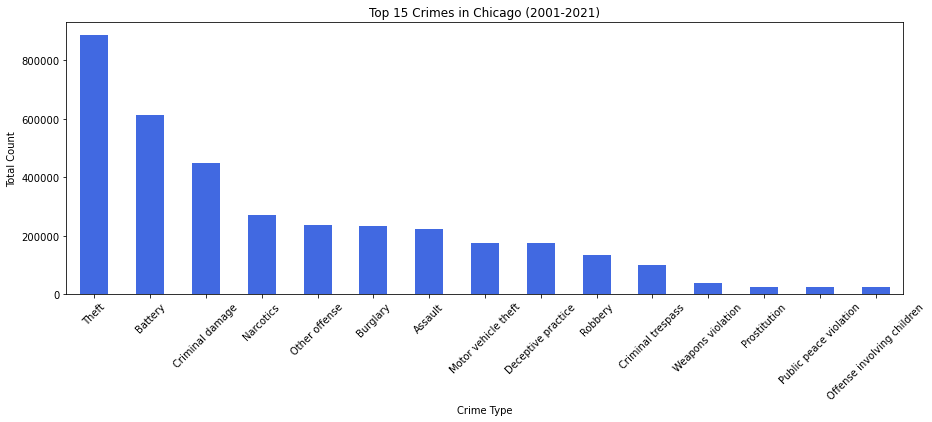

In [117]:
df_summary_by_type = df_crime_house.groupby('primary_type')['primary_type'].count().sort_values(ascending=False)
df_summary_by_type = df_summary_by_type.to_frame()
df_summary_by_type = df_summary_by_type.rename(columns={'primary_type':'count'})
df_top15_by_type = df_summary_by_type.head(15)
df_top15_by_type = df_top15_by_type.reset_index()
df_top15_by_type['primary_type'] = df_top15_by_type['primary_type'].apply(lambda x: str(x)[0]+str(x)[1:].lower())

#bar chart for top 15
f,a = plt.subplots(figsize=(15,5))

df_top15_by_type.plot(kind='bar',x='primary_type',y='count',ax=a,color='royalblue',legend=None)
plt.xlabel('Crime Type')
a.tick_params(axis='x',rotation=45)
plt.ylabel('Total Count')
plt.title('Top 15 Crimes in Chicago (2001-2021)')

plt.show()

## 2.3. Crime in Each Community Area

In [20]:
#reformat the dataframe to get the count for each type of crime, each month, and each community area
df_crime_house_count = df_crime_house.groupby(['community_area','month','price','population','primary_type'])['primary_type'].count()
df_crime_house_count = df_crime_house_count.to_frame()
df_crime_house_count = df_crime_house_count.rename(columns={'primary_type':'count'})

In [22]:
#reformat the dataframe for ease of analysis
df_crime_house_count_pivot = df_crime_house_count.reset_index()
df_crime_house_count_pivot['primary_type'] = df_crime_house_count_pivot['primary_type'].apply(lambda x: str(x).replace(' ','_').lower())
df_crime_house_count_pivot = df_crime_house_count_pivot.pivot(index=('community_area','month','price','population'),columns='primary_type',values='count')
df_crime_house_count_pivot['sum'] = df_crime_house_count_pivot.sum(axis=1)
df_crime_house_count_pivot = df_crime_house_count_pivot.reset_index()
df_crime_house_count_pivot['crime_rate_%'] = df_crime_house_count_pivot['sum']/df_crime_house_count_pivot['population']*100
df_crime_house_count_pivot = df_crime_house_count_pivot.set_index(['community_area','month','population'])
df_crime_house_count_pivot.columns.name = ''

In [34]:
#create individual dataframe for each community area with monthly percentage price change
#remove 2001 and 2002 entries due to what seems to be an under-counting issue
def get_crime_house_count_dfs(df_reindexed,list_community_area):
    frames = {'df_crime_house_count_'+area.replace(' ','_').lower(): df_reindexed.loc[area] for area in list_relevant_commu}
    list_keys = list(frames.keys())
    for key in list_keys:
        frame = frames.get(key)
        if key == 'df_crime_house_count_albany_park':
            frame = frame.drop(frame.index[range(23)])
            frame['crime_percentage_change'] = frame.pct_change()['sum']*100
            frame['price_percentage_change'] = frame.pct_change()['price']*100
            frames[key] = frame
        else:
            frame = frame.drop(frame.index[range(24)])
            frame['crime_percentage_change'] = frame.pct_change()['sum']*100
            frame['price_percentage_change'] = frame.pct_change()['price']*100
            frames[key] = frame
    return frames

dict_crime_house_count_dfs = get_crime_house_count_dfs(df_crime_house_count_pivot,list_relevant_commu)

#create individual dataframe for each community area with monthly percentage price change
#remove 2001 and 2002 entries to match the crime dataset
def get_house_dfs(df_reindexed,list_community_area):
    frames = {'df_house_'+area.replace(' ','_').lower(): df_reindexed.loc[area] for area in list_relevant_commu}
    list_keys = list(frames.keys())
    for key in list_keys:
        frame = frames.get(key)
        frame = frame.drop(frame.index[range(24)])
        frame['price_percentage_change'] = frame.pct_change()*100
        frames[key] = frame
    return frames

dict_house_dfs = get_house_dfs(df_house_chicago_reindex,list_relevant_commu)

The section below defines three functions that plot the monthly crime count, monthly crime percentage change, and monthly crime rate trend over time. Areas that experienced significant monthly crime percentage change are those with low crime counts. In addition, the trends seem to exhibit a seasonal pattern, which is widely discussed in many related literature. 

In [32]:
#plot monthly crime count for all community areas
def get_crime_count():
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1

    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_key = list(dict_crime_house_count_dfs.keys())
    list_val = list(dict_crime_house_count_dfs.values())

    for key,val in zip(list_key,list_val):
        area = key.split('count_')[1]
        plt.subplot(a,b,c)
        plt.title(area+' monthly crime count')
        plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        plt.ylabel(' ')
        plt.ylim([0,1500])
        plt.yticks(np.arange(0,2000,500))
        sns.lineplot(data=val.reset_index(),x='month',y='sum',legend=None)
        c = c+1

    plt.show()
    
#plot monthly crime count percentage change for all community areas
def get_crime_change():
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1

    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_key = list(dict_crime_house_count_dfs.keys())
    list_val = list(dict_crime_house_count_dfs.values())

    for key,val in zip(list_key,list_val):
        area = key.split('count_')[1]
        plt.subplot(a,b,c)
        plt.title(area+' monthly crime % change')
        plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        plt.axhline(0,color='black',ls='--',lw=1)
        plt.ylabel(' ')
        plt.ylim([-100,100])
        sns.lineplot(data=val.reset_index(),x='month',y='crime_percentage_change',legend=None)
        c = c+1

    plt.show()
    
#plot monthly crime rate for all community areas
def get_crime_rate():
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1

    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_key = list(dict_crime_house_count_dfs.keys())
    list_val = list(dict_crime_house_count_dfs.values())

    for key,val in zip(list_key,list_val):
        area = key.split('count_')[1]
        plt.subplot(a,b,c)
        plt.title(area+' monthly crime rate %')
        plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        plt.ylabel(' ')
        plt.ylim([0,4])
        plt.yticks(np.arange(0,5,2))
        sns.lineplot(data=val.reset_index(),x='month',y='crime_rate_%',legend=None)
        c = c+1

    plt.show()

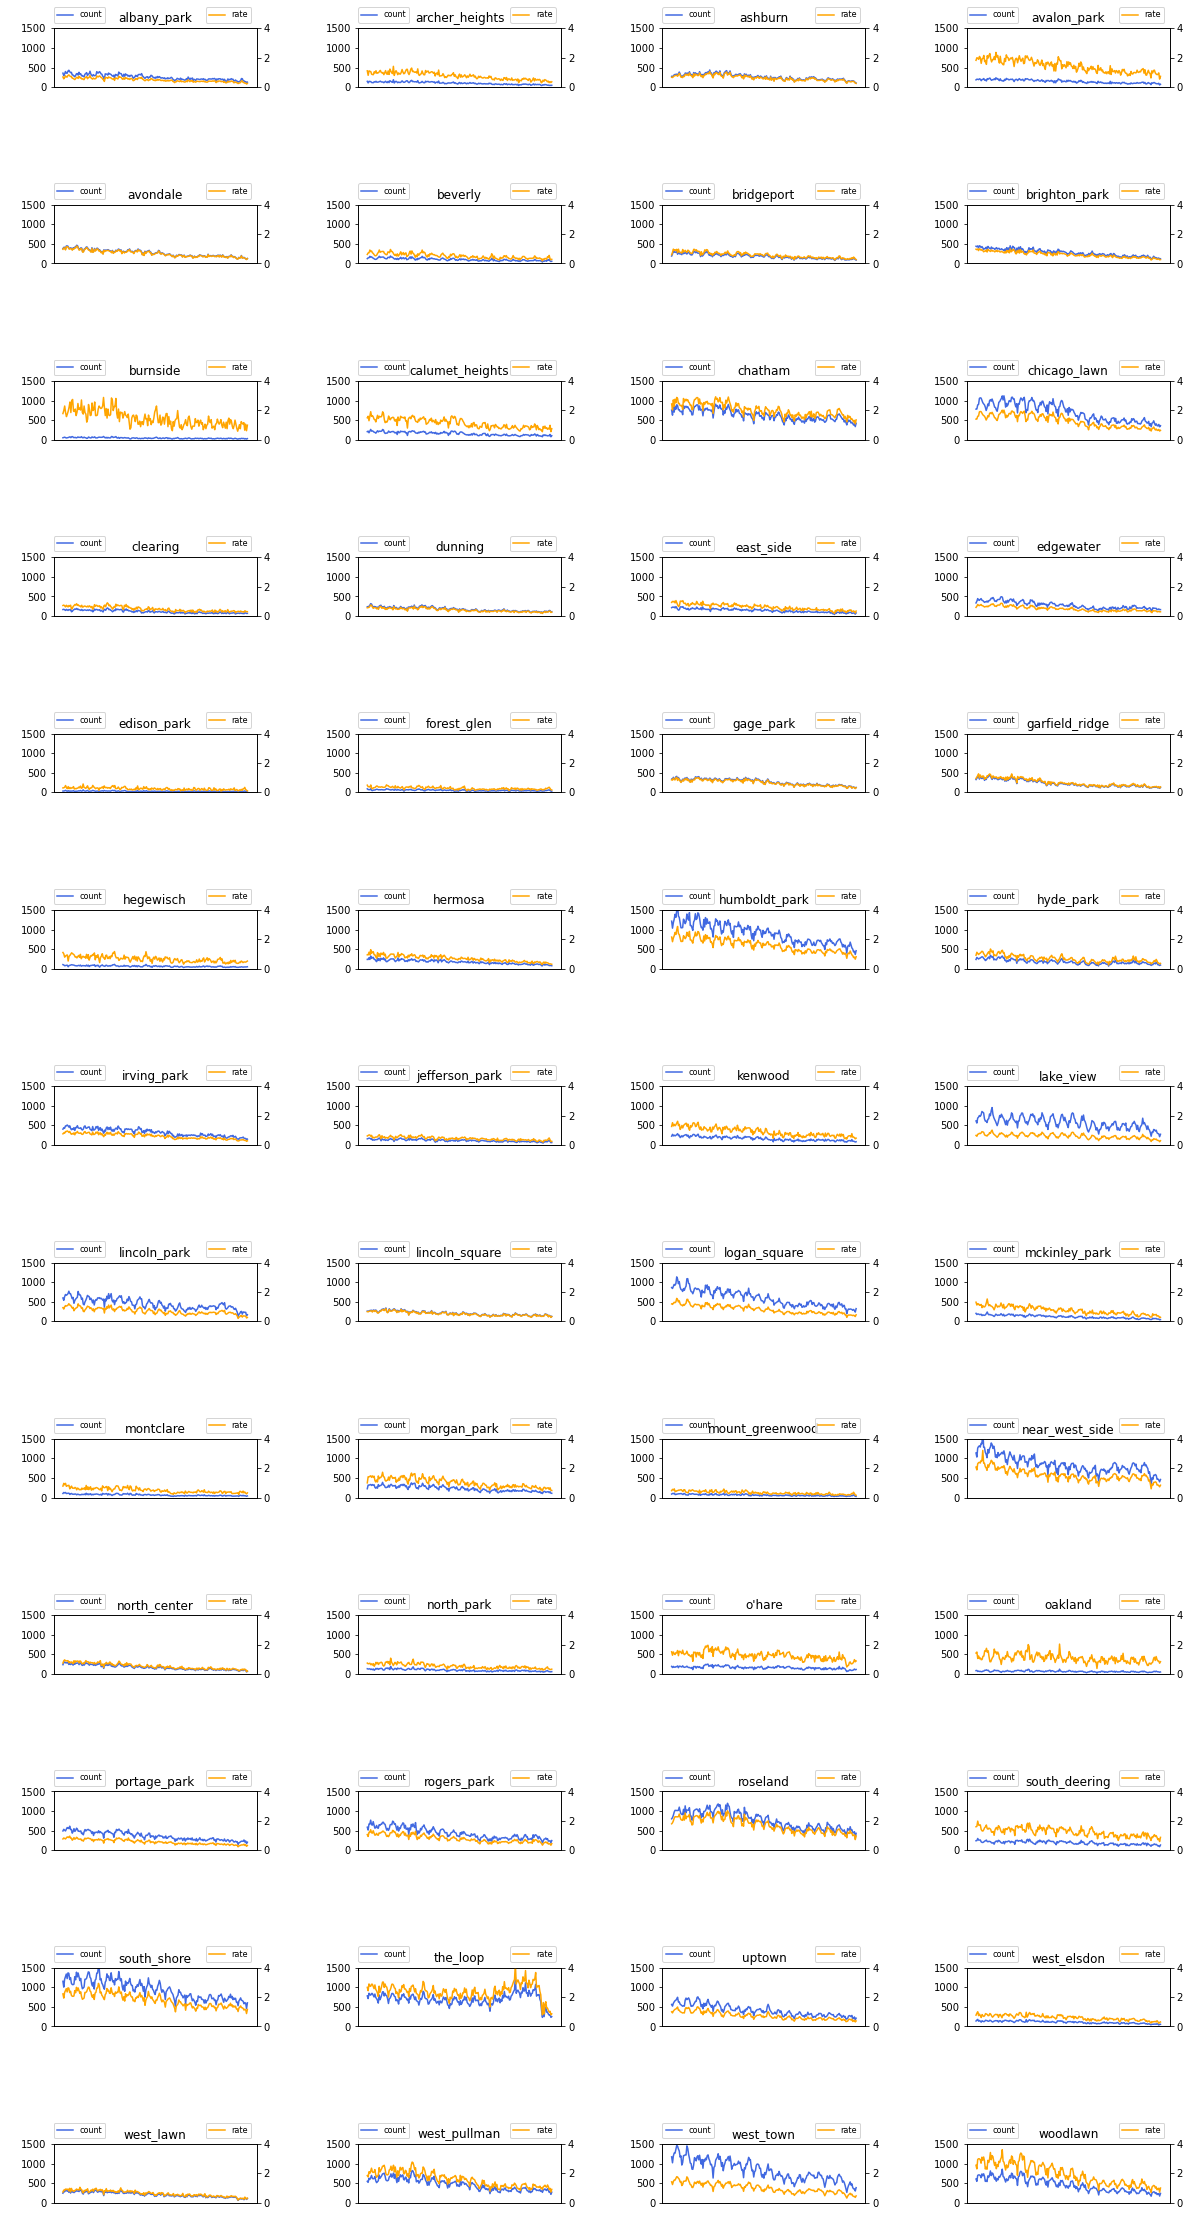

In [121]:
#plot monthly crime count with crime rate
#number of rows
a = 13
#number of columns
b = 4

f,a = plt.subplots(a,b,figsize=(20,40))

row = 0
col = 0

f.subplots_adjust(hspace = 2,wspace=0.5)
list_house_key = list(dict_house_dfs.keys())
list_house_val = list(dict_house_dfs.values())
list_crime_key = list(dict_crime_house_count_dfs.keys())
list_crime_val = list(dict_crime_house_count_dfs.values())

for i in range(52):
    area = list_house_key[i].split('house_')[1]
    
    a[row][col].plot(list_crime_val[i].reset_index()['month'],list_crime_val[i].reset_index()['sum'],color='royalblue')
    a[row][col].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    a[row][col].set_ylabel(' ')
    a[row][col].set_ylim([0,1500])
    a[row][col].set_yticks(np.arange(0,2000,500))
    a[row][col].legend(labels=['count'],loc=(0,1.1),prop={'size': 8})
    
    ap = a[row][col].twinx()
    ap.plot(list_crime_val[i].reset_index()['month'],list_crime_val[i].reset_index()['crime_rate_%'],color='orange')
    ap.set_ylabel(' ')
    ap.set_ylim([0,4])
    ap.set_yticks(np.arange(0,5,2))
    
    col = col+1
    if col <= 3:
        row = row
    else:
        row = row+1
        col=0
    
    plt.legend(labels=['rate'],loc=(0.75,1.1),prop={'size': 8})
    plt.title(area)
    
plt.show()

Most of the community areas exhibit a downward sloping trend for crime count and crime rate. One interesting observation is the sharp drop in crime for the Loop area during the year 2020. It could be due to the lockdown reducing the number of people traveling to the site for work. 

From the graph, we can observe areas such as Chicago Lawn, Humboldt Park, Logan Square, Near West Side, South Shore, and West Town where monthly crime count dropped from over 1000 to below 500.

The section below will hightlight these areas on the map.

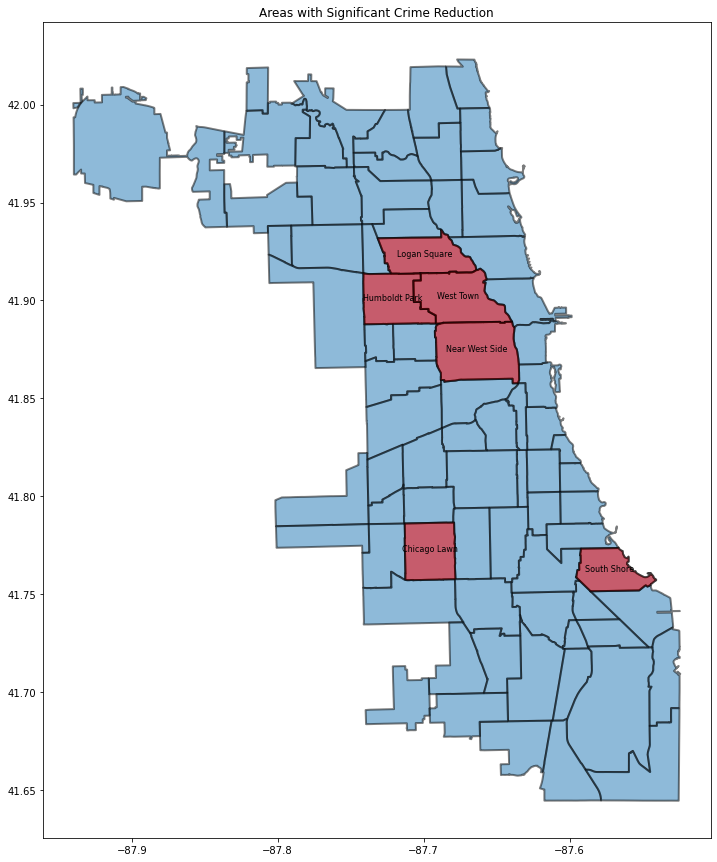

In [125]:
#highlight the areas of interest on the map
list_area_of_interest = ['CHICAGO LAWN','HUMBOLDT PARK','LOGAN SQUARE','NEAR WEST SIDE','SOUTH SHORE','WEST TOWN']
chicago_geo_interest = chicago_geo.loc[chicago_geo['community'].isin(list_area_of_interest)]

f,a = plt.subplots(figsize=(15,15))

#background map 
chicago_map = chicago_geo.plot(edgecolor='k',alpha=0.5,linewidth=2,ax=a)

#highlight and annotate community areas of interest
chicago_map_interest = chicago_geo_interest.plot(edgecolor='k',color='red',alpha=0.5,linewidth=2,ax=a)
chicago_geo_interest.apply(lambda x: chicago_map.text(s=x.community.title(),x=x.geometry.centroid.coords[0][0],y=x.geometry.centroid.coords[0][1],ha='center',size=8),axis=1)

plt.title('Areas with Significant Crime Reduction')
plt.show()

There seems to be a cluster of areas in the central and northern part of Chicago that successfully reduced overall criminal activities. It could be interesting to investigate further the reasons behind this success, such as gentrification or improved policing strategy. 

## 2.4. Crime and Housing Prices 

We are using housing price data from Zillow home value index in this analysis. It represents a smoothed, seasonally adjusted measure of typical home value across region and housing type. It reflects the typical value for homes in the 35th to 65th percentile range. When it comes to housing price trends over the past two decades, most community areas exhibit a similar pattern: upward movement before the financial crisis, downward during the recession, and upward again during recent years. 

In [128]:
#plot monthly price percentage change for all community areas
def get_house_change():
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1

    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_key = list(dict_house_dfs.keys())
    list_val = list(dict_house_dfs.values())

    for key,val in zip(list_key,list_val):
        area = key.split('house_')[1]
        plt.subplot(a,b,c)
        plt.title(area+' monthly price % change')
        plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        plt.axhline(0,color='black',ls='--',lw=1)
        plt.ylabel(' ')
        plt.ylim([-3,3])
        sns.lineplot(data=val.reset_index(),x='month',y='price_percentage_change',legend=None)
        c = c+1

    plt.show()
    
#plot monthly housing price percentage change with monthly crime rate togher
def get_house_change_crime_rate():
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1
 
    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_house_key = list(dict_house_dfs.keys())
    list_house_val = list(dict_house_dfs.values())
    list_crime_key = list(dict_crime_house_count_dfs.keys())
    list_crime_val = list(dict_crime_house_count_dfs.values())

    for i in range(52):
        area = list_house_key[i].split('house_')[1]
        plt.subplot(a,b,c)
        plt.title(area)
        plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        sns.lineplot(data=list_house_val[i].reset_index(),x='month',y='price_percentage_change')
        sns.lineplot(data=list_crime_val[i].reset_index(),x='month',y='crime_rate_%')
        plt.ylabel(' ')
        plt.ylim([-3,4])
        plt.legend(labels=['price %','crime %'],bbox_to_anchor=(1.01,1),prop={'size': 8})
        c = c+1
    
    plt.show()
    
#plot monthly housing price with monthly crime rate togher
def get_house_crime_rate():
    #number of rows
    a = 13
    #number of columns
    b = 4

    f,a = plt.subplots(a,b,figsize=(20,40))

    row = 0
    col = 0

    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_house_key = list(dict_house_dfs.keys())
    list_house_val = list(dict_house_dfs.values())
    list_crime_key = list(dict_crime_house_count_dfs.keys())
    list_crime_val = list(dict_crime_house_count_dfs.values())

    for i in range(52):
        area = list_house_key[i].split('house_')[1]
    
        a[row][col].plot(list_house_val[i].reset_index()['month'],list_house_val[i].reset_index()['price'],color='royalblue')
        a[row][col].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        a[row][col].set_ylabel(' ')
        a[row][col].set_ylim([0,750000])
        a[row][col].set_yticks(np.arange(0,1000000,400000))
        a[row][col].legend(labels=['price'],loc=(0,1.1),prop={'size': 8})
    
        ap = a[row][col].twinx()
        ap.plot(list_crime_val[i].reset_index()['month'],list_crime_val[i].reset_index()['crime_rate_%'],color='orange')
        ap.set_ylabel(' ')
        ap.set_ylim([0,4])
        ap.set_yticks(np.arange(0,5,2))
    
        col = col+1
        if col <= 3:
            row = row
        else:
            row = row+1
            col=0
    
        plt.legend(labels=['crime %'],loc=(0.75,1.1),prop={'size': 8})
        plt.title(area)
    
    plt.show() 

The graphs below represent the monthly housing price and crime rate trend from 2003 to 2021 for 52 community areas in Chicago.

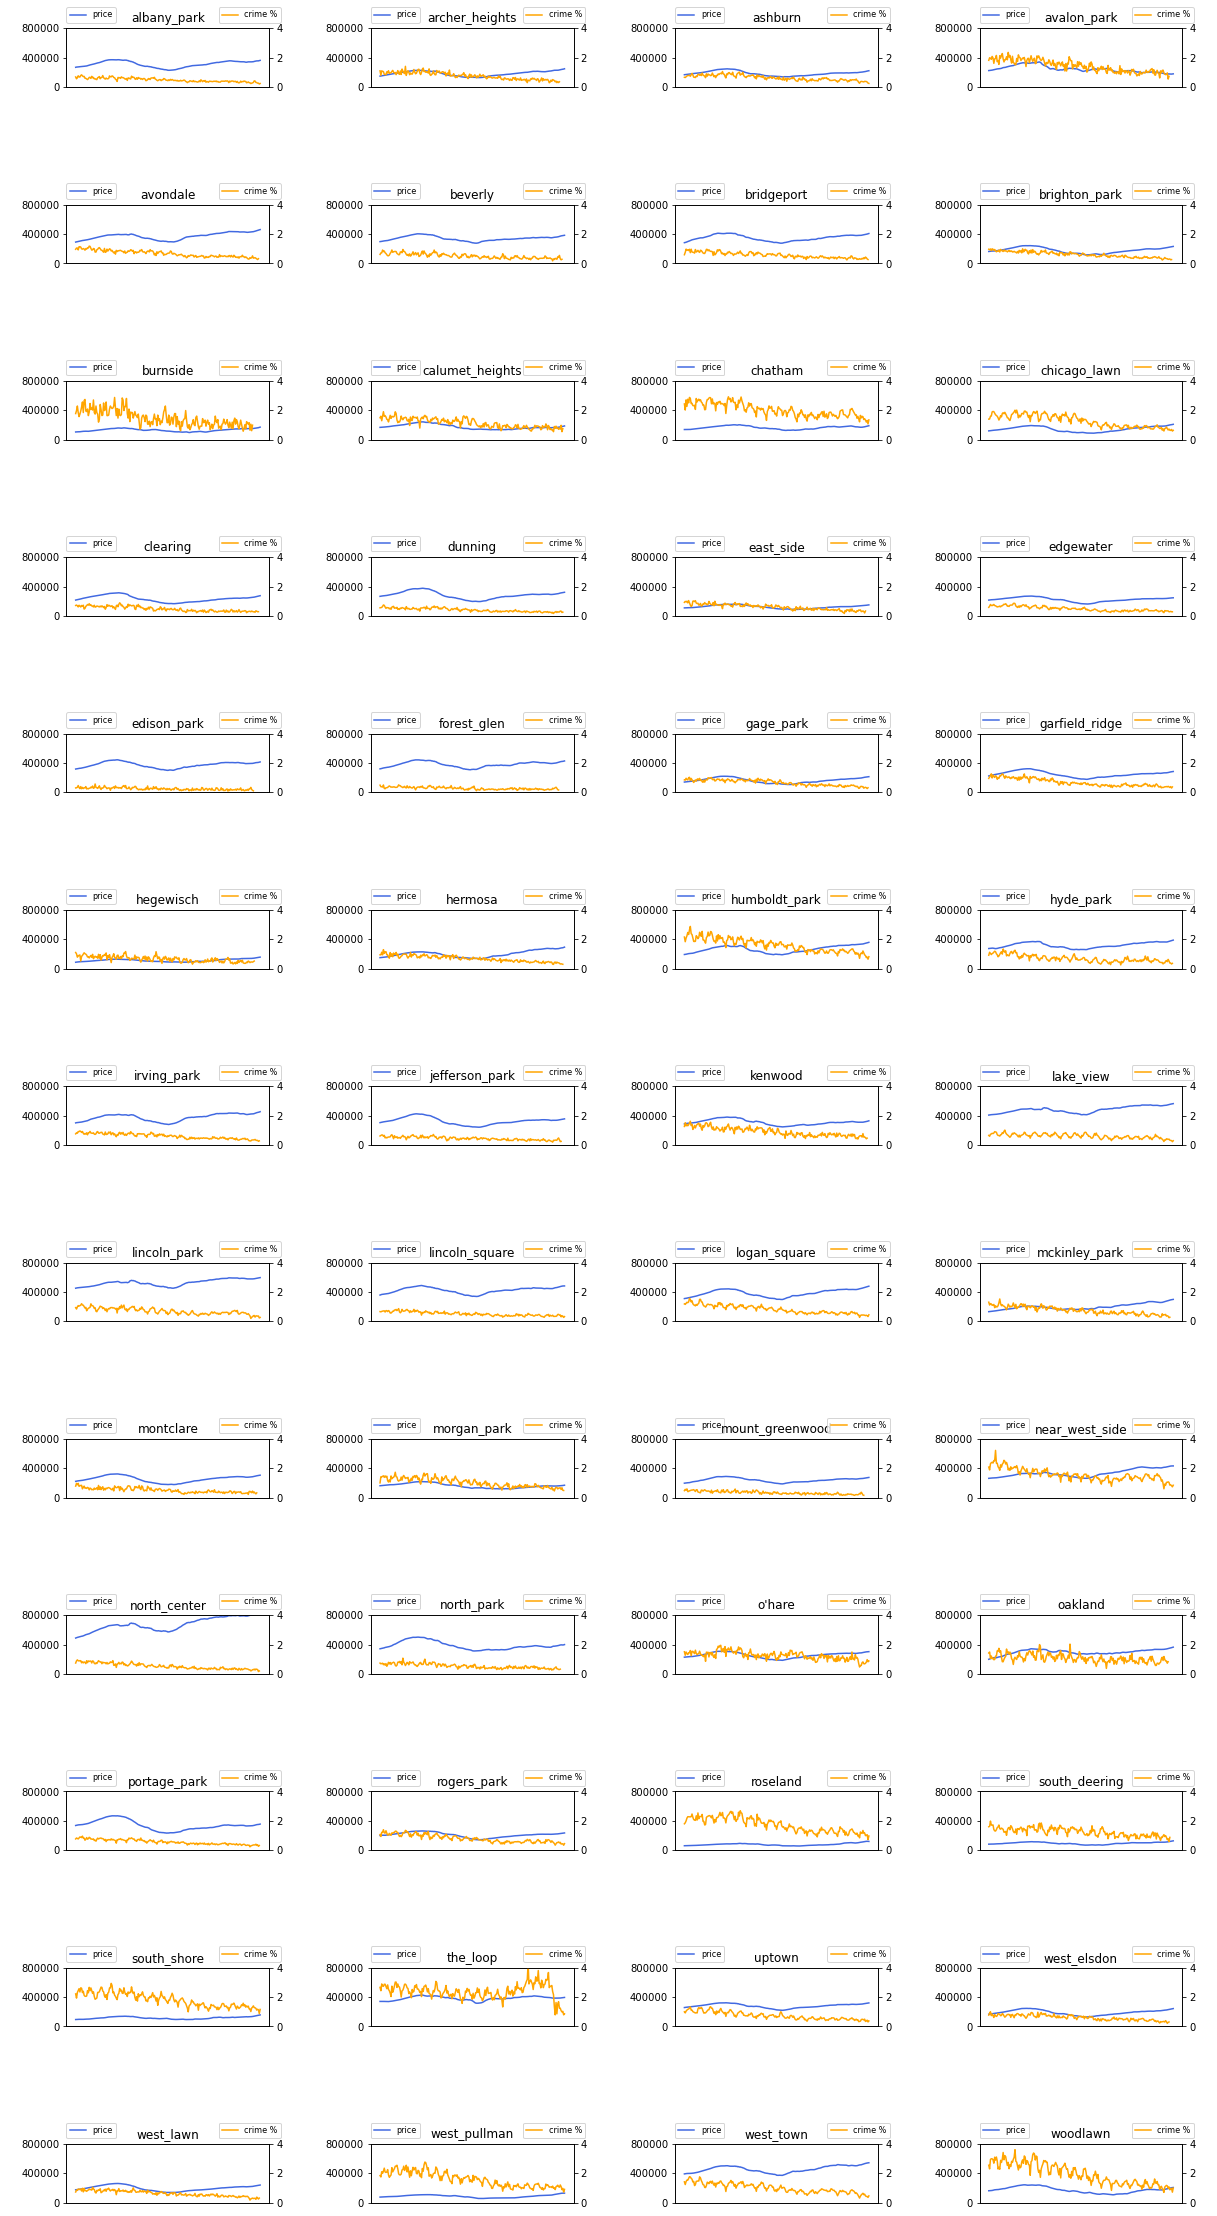

In [129]:
get_house_crime_rate()

To find out the relationship between crime rate and housing price, we will calculate the correlation between monthly crime rate and housing price for each community area. We also consider crime rate from one month and two months ago to accommodate for potential delayed reaction of the housing market to crime. 

In [99]:
#plot log monthly housing price with monthly crime rate (scatter, no lag) and obtain correlation series
def get_corr_house_crime_rate(plot_trigger):
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1

    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_key = list(dict_crime_house_count_dfs.keys())
    list_val = list(dict_crime_house_count_dfs.values())
    corr_price_crime_rate = []
    
    #set plot_trigger as yes if graphs are needed
    if plot_trigger == 'yes':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            corr = round(val.reset_index()['crime_rate_%'].corr(val.reset_index()['price']),4)
            corr_price_crime_rate.append(corr)
            plt.subplot(a,b,c)
            plt.title(area+' (corr: '+str(corr)+')')
            plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
            plt.ylim([0,4])
            sns.regplot(data=val.reset_index(),x='price',y='crime_rate_%',marker='+',line_kws={'color': 'cyan'})
            plt.xlabel('price')
            plt.ylabel('crime rate %')
            c = c+1 
        plt.show()
    if plot_trigger == 'no':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            corr = round(val.reset_index()['crime_rate_%'].corr(val.reset_index()['price']),4)
            corr_price_crime_rate.append(corr)
        return corr_price_crime_rate
        
    
#plot log monthly housing price with monthly crime rate (scatter, one month lag) and obtain correlation series
def get_corr_house_crime_rate_lag_1(plot_trigger):
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1

    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_key = list(dict_crime_house_count_dfs.keys())
    list_val = list(dict_crime_house_count_dfs.values())
    corr_price_crime_rate_lag_1 = []
    
    #set plot_trigger as yes if graphs are needed
    if plot_trigger == 'yes':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            val['crime_rate_%_lag_1'] = val['crime_rate_%'].shift(-1)
            corr = round(val.reset_index()['crime_rate_%_lag_1'].corr(val.reset_index()['price']),4)
            corr_price_crime_rate_lag_1.append(corr)
            plt.subplot(a,b,c)
            plt.title(area+' (corr: '+str(corr)+')')
            plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
            plt.ylim([0,4])
            sns.regplot(data=val.reset_index(),x='price',y='crime_rate_%_lag_1',marker='+',line_kws={'color': 'cyan'})
            plt.xlabel('price')
            plt.ylabel('crime rate % lag 1')
            c = c+1
        plt.show()
    if plot_trigger == 'no':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            val['crime_rate_%_lag_1'] = val['crime_rate_%'].shift(-1)
            corr = round(val.reset_index()['crime_rate_%_lag_1'].corr(val.reset_index()['price']),4)
            corr_price_crime_rate_lag_1.append(corr)
        return corr_price_crime_rate_lag_1
    
#plot log monthly housing price with monthly crime rate (scatter, two months lag) and obtain correlation series
def get_corr_house_crime_rate_lag_2(plot_trigger):
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1

    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_key = list(dict_crime_house_count_dfs.keys())
    list_val = list(dict_crime_house_count_dfs.values())
    corr_price_crime_rate_lag_2 = []
    
    #set plot_trigger as yes if graphs are needed
    if plot_trigger == 'yes':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            val['crime_rate_%_lag_2'] = val['crime_rate_%'].shift(-2)
            corr = round(val.reset_index()['crime_rate_%_lag_2'].corr(val.reset_index()['price']),4)
            corr_price_crime_rate_lag_2.append(corr)
            plt.subplot(a,b,c)
            plt.title(area+' (corr: '+str(corr)+')')
            plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
            plt.ylim([0,4])
            sns.regplot(data=val.reset_index(),x='price',y='crime_rate_%_lag_2',marker='+',line_kws={'color': 'cyan'})
            plt.xlabel('price')
            plt.ylabel('crime rate % lag 2')
            c = c+1
        plt.show()
    if plot_trigger == 'no':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            val['crime_rate_%_lag_2'] = val['crime_rate_%'].shift(-2)
            corr = round(val.reset_index()['crime_rate_%_lag_2'].corr(val.reset_index()['price']),4)
            corr_price_crime_rate_lag_2.append(corr)
        return corr_price_crime_rate_lag_2

In [100]:
#run the above functions without plotting 
corr_price_crime_rate = get_corr_house_crime_rate('no')
corr_price_crime_rate_lag_1 = get_corr_house_crime_rate_lag_1('no')
corr_price_crime_rate_lag_2 = get_corr_house_crime_rate_lag_2('no')

#correlation tablel between price and crime rate
df_corr_price_crime_rate = pd.DataFrame(list(zip(list_relevant_commu,corr_price_crime_rate,corr_price_crime_rate_lag_1,corr_price_crime_rate_lag_2)),
                                       columns=['community_area','corr_price_crime_rate','corr_price_crime_rate_lag_1','corr_price_crime_rate_lag_2'])

#add median price to the correlation table
#median housing price
list_val = list(dict_crime_house_count_dfs.values())
median_price = []

for val in list_val:
    median = val.reset_index()['price'].median()
    median_price.append(median)
    
df_corr_price_crime_rate['median_price'] = median_price

#add population to the correlation table
list_val = list(dict_crime_house_count_dfs.values())
population = []

for val in list_val:
    pop = val.reset_index()['population'].median()
    population.append(pop)
    
df_corr_price_crime_rate['population'] = population

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

In [101]:
#print out the dataframe that sort the correlation from most strongly negative to most strongly positive
df_corr_price_crime_rate.sort_values(by=['corr_price_crime_rate'])

,community_area,corr_price_crime_rate,corr_price_crime_rate_lag_1,corr_price_crime_rate_lag_2,median_price,population
36,North Center,-0.7643,-0.7626,-0.7590,663925.5,31867.0
31,McKinley Park,-0.6890,-0.6811,-0.6752,192619.0,15612.0
27,Lake View,-0.5795,-0.5752,-0.5746,485867.0,94368.0
4,Avondale,-0.5466,-0.5376,-0.5269,380973.0,39262.0
35,Near West Side,-0.5012,-0.4967,-0.4942,325350.0,54881.0
28,Lincoln Park,-0.4899,-0.4801,-0.4730,529784.0,64116.0
21,Hermosa,-0.4864,-0.4777,-0.4694,204128.0,25010.0
24,Irving Park,-0.4474,-0.4381,-0.4267,387007.5,53359.0
22,Humboldt Park,-0.3800,-0.3710,-0.3673,267102.0,56323.0
50,West Town,-0.3333,-0.3195,-0.3090,454893.0,82236.0


The correlations between monthly housing price and the crime rate of the same month, of the previous month, or of two months ago are similar for most areas. Moreover, the correlations differ significantly among community areas. Contrary to conventional wisdom, some areas have strong positive correlations between crime and housing price. We suspect that the housing prices in those areas could be more sensitive to non-crime factors. To find out more about the common characteristics for community areas that exhibit similar price-crime rate correlations, we will create a scatter plot for the correlation values and the median housing prices.

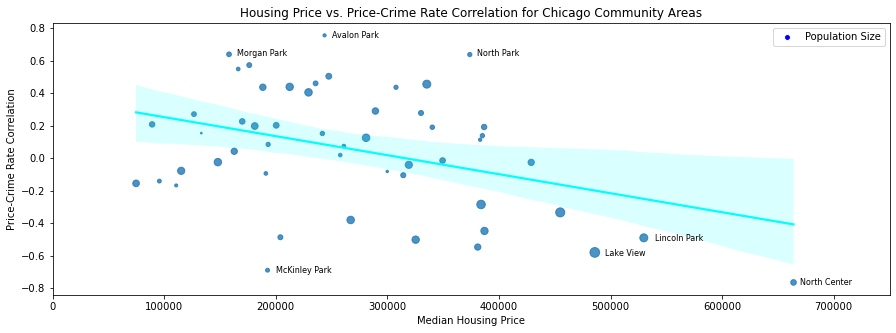

In [90]:
#plot median price and price-crime rate correlation with population as marker size
f,a = plt.subplots(figsize=(15,5))

sns.regplot(data=df_corr_price_crime_rate,x='median_price',y='corr_price_crime_rate',marker='o',
            line_kws={'color': 'cyan'},scatter_kws={'s':df_corr_price_crime_rate['population']/1000})
plt.xlim([0,750000])
plt.xlabel('Median Housing Price')
plt.ylabel('Price-Crime Rate Correlation')
plt.title('Housing Price vs. Price-Crime Rate Correlation for Chicago Community Areas')
item = [Line2D([0],[0],color='w',marker='o',markerfacecolor='blue',label='Population Size')]
plt.legend(handles=item)

plt.text(165000,0.63,'Morgan Park',fontsize=8)
plt.text(200000,-0.705,'McKinley Park',fontsize=8)
plt.text(250000,0.74,'Avalon Park',fontsize=8)
plt.text(380000,0.63,'North Park',fontsize=8)
plt.text(495000,-0.6,'Lake View',fontsize=8)
plt.text(540000,-0.51,'Lincoln Park',fontsize=8)
plt.text(670000, -0.78,'North Center',fontsize=8)

plt.show()

Overall, the correlation becomes more negative as the median housing price increases. Our intuition is that as the community area gets richer, other amenities such as parks and schools also get better. Given those amenities, the housing market becomes more sensitive to factors like crime rate. Similar to Maslow's Hierarchy of Needs, if basic infrastructures are lacking, the level of criminal activities might not be housing market participants' primary concern.

Also, the population size of each community area does not seem to have a noticeable impact on the price-correlation relationship.

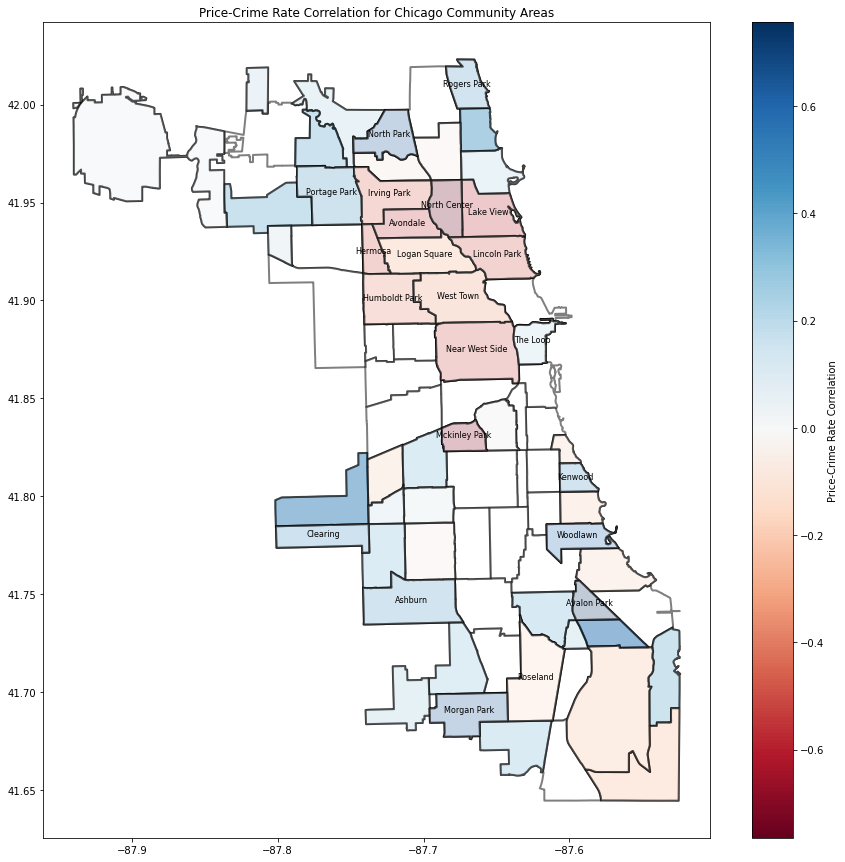

In [132]:
#plotting correlation on the map
#remove unwanted areas from the geo dataframe
list_area_of_interest = [x.upper() for x in df_corr_price_crime_rate['community_area'].tolist()]
chicago_geo.loc[37,'community'] = 'THE LOOP'
chicago_geo.loc[74,'community'] = "O'HARE"
chicago_geo_interest = chicago_geo.loc[chicago_geo['community'].isin(list_area_of_interest)]
chicago_geo_interest = chicago_geo_interest.sort_values(by=['community'])

f,a = plt.subplots(figsize=(15,15))

list_area_of_interest_alt = ['North Center','McKinley Park','Lake View','Avondale','Near West Side','Lincoln Park',
                             'Hermosa','Irving Park','Humboldt Park','West Town','Logan Square','Roseland',
                             'Kenwood','Ashburn','Rogers Park','Portage Park','Clearing','Woodlawn','The LOOP',
                             'North Park','Morgan Park','Avalon Park']
list_area_of_interest_alt = [x.upper() for x in list_area_of_interest_alt]
chicago_geo_interest_alt = chicago_geo.loc[chicago_geo['community'].isin(list_area_of_interest_alt)]

#background map that includes all 77 community areas
chicago_map = chicago_geo.plot(edgecolor='k',alpha=0.5,linewidth=2,ax=a,color='white')

#plot the relevant community areas on top of the background map  
chicago_map_interest = chicago_geo_interest.plot(column=df_corr_price_crime_rate['corr_price_crime_rate'],edgecolor='k',alpha=0.5,linewidth=2,ax=a,cmap='RdBu',legend=True,
                                                 legend_kwds={'label': 'Price-Crime Rate Correlation'})

#background map for annotation
chicago_map_interest_alt = chicago_geo_interest_alt.plot(edgecolor='k',alpha=0.5,linewidth=2,ax=a,color='white')

#only annotate the areas listed above
chicago_geo_interest_alt.apply(lambda x: chicago_map_interest_alt.text(s=x.community.title(),x=x.geometry.centroid.coords[0][0],y=x.geometry.centroid.coords[0][1],ha='center',size=8),axis=1)

plt.title('Price-Crime Rate Correlation for Chicago Community Areas')
plt.show()

Plotting the results on the map, we observe a familiar cluster in the northern part of Chicago where the correlation between the crime rate and the housing price is strongly negative. Many community areas in this region have high median housing price. 

On the one hand, this observation supports our conjecture that the housing markets in affluent areas are more sensitive to crime rate changes due to other factors that affect housing prices, such as parks and schools are already of a high standard. 

On the other hand, our early result shows that community areas in this cluster successfully reduced crime count and crime rate during the past two decades. The negative correlation between price and crime rate is destined to be stronger for these areas due to the drastic decrease in crime. 

In a nutshell, we need additional evidence to establish a causal link between an area's economic condition and its housing market's sensitivity to crime changes.

We conduct similar analysis for monthly housing price percentage change and monthly crime percentage change. We include crime percentage change up to four months before the current month. 

In [106]:
#plot monthly housing price percentage change with monthly crime percentage change (scatter, no lag) and obtain correlation series
def get_corr_house_crime_change(plot_trigger):
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1

    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_key = list(dict_crime_house_count_dfs.keys())
    list_val = list(dict_crime_house_count_dfs.values())
    corr_price_crime_change = []
    
    #set plot_trigger as yes if graphs are needed
    if plot_trigger == 'yes':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            corr = round(val.reset_index()['crime_percentage_change'].corr(val.reset_index()['price_percentage_change']),4)
            corr_price_crime_change.append(corr)
            plt.subplot(a,b,c)
            plt.title(area+' (corr: '+str(corr)+')')
            plt.xlim([-75,75])
            plt.ylim([-3,3])
            sns.regplot(data=val.reset_index(),x='crime_percentage_change',y='price_percentage_change',marker='+',line_kws={'color': 'cyan'})
            plt.xlabel('crime % change')
            plt.ylabel('price % change')
            c = c+1
        plt.show()
    if plot_trigger == 'no':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            corr = round(val.reset_index()['crime_percentage_change'].corr(val.reset_index()['price_percentage_change']),4)
            corr_price_crime_change.append(corr)
        return corr_price_crime_change

#plot monthly housing price percentage change with monthly crime percentage change (scatter, one month lag for crime) and obtain correlation series
def get_corr_house_crime_change_lag_1(plot_trigger):
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1

    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_key = list(dict_crime_house_count_dfs.keys())
    list_val = list(dict_crime_house_count_dfs.values())
    corr_price_crime_change_lag_1 = []

    #set plot_trigger as yes if graphs are needed
    if plot_trigger == 'yes':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            val['crime_percentage_change_lag_1'] = val['crime_percentage_change'].shift(-1)
            corr = round(val.reset_index()['crime_percentage_change_lag_1'].corr(val.reset_index()['price_percentage_change']),4)
            corr_price_crime_change_lag_1.append(corr)
            plt.subplot(a,b,c)
            plt.title(area+' (corr: '+str(corr)+')')
            plt.xlim([-75,75])
            plt.ylim([-3,3])
            sns.regplot(data=val.reset_index(),x='crime_percentage_change_lag_1',y='price_percentage_change',marker='+',line_kws={'color': 'cyan'})
            plt.xlabel('crime % change lag 1')
            plt.ylabel('price % change')
            c = c+1
        plt.show()
    if plot_trigger == 'no':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            val['crime_percentage_change_lag_1'] = val['crime_percentage_change'].shift(-1)
            corr = round(val.reset_index()['crime_percentage_change_lag_1'].corr(val.reset_index()['price_percentage_change']),4)
            corr_price_crime_change_lag_1.append(corr)
        return corr_price_crime_change_lag_1
    
#plot monthly housing price percentage change with monthly crime percentage change (scatter, two months lag for crime) and obtain correlation series
def get_corr_house_crime_change_lag_2(plot_trigger):
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1

    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_key = list(dict_crime_house_count_dfs.keys())
    list_val = list(dict_crime_house_count_dfs.values())
    corr_price_crime_change_lag_2 = []

    #set plot_trigger as yes if graphs are needed
    if plot_trigger == 'yes':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            val['crime_percentage_change_lag_2'] = val['crime_percentage_change'].shift(-2)
            corr = round(val.reset_index()['crime_percentage_change_lag_2'].corr(val.reset_index()['price_percentage_change']),4)
            corr_price_crime_change_lag_2.append(corr)
            plt.subplot(a,b,c)
            plt.title(area+' (corr: '+str(corr)+')')
            plt.xlim([-75,75])
            plt.ylim([-3,3])
            sns.regplot(data=val.reset_index(),x='crime_percentage_change_lag_2',y='price_percentage_change',marker='+',line_kws={'color': 'cyan'})
            plt.xlabel('crime % change lag 2')
            plt.ylabel('price % change')
            c = c+1
        plt.show()
    if plot_trigger == 'no':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            val['crime_percentage_change_lag_2'] = val['crime_percentage_change'].shift(-2)
            corr = round(val.reset_index()['crime_percentage_change_lag_2'].corr(val.reset_index()['price_percentage_change']),4)
            corr_price_crime_change_lag_2.append(corr)
        return corr_price_crime_change_lag_2
    
#plot monthly housing price percentage change with monthly crime percentage change (scatter, three months lag for crime) and obtain correlation series
def get_corr_house_crime_change_lag_3(plot_trigger):
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1

    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_key = list(dict_crime_house_count_dfs.keys())
    list_val = list(dict_crime_house_count_dfs.values())
    corr_price_crime_change_lag_3 = []

    #set plot_trigger as yes if graphs are needed
    if plot_trigger == 'yes':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            val['crime_percentage_change_lag_3'] = val['crime_percentage_change'].shift(-3)
            corr = round(val.reset_index()['crime_percentage_change_lag_3'].corr(val.reset_index()['price_percentage_change']),4)
            corr_price_crime_change_lag_3.append(corr)
            plt.subplot(a,b,c)
            plt.title(area+' (corr: '+str(corr)+')')
            plt.xlim([-75,75])
            plt.ylim([-3,3])
            sns.regplot(data=val.reset_index(),x='crime_percentage_change_lag_3',y='price_percentage_change',marker='+',line_kws={'color': 'cyan'})
            plt.xlabel('crime % change lag 3')
            plt.ylabel('price % change')
            c = c+1
        plt.show()
    if plot_trigger == 'no':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            val['crime_percentage_change_lag_3'] = val['crime_percentage_change'].shift(-3)
            corr = round(val.reset_index()['crime_percentage_change_lag_3'].corr(val.reset_index()['price_percentage_change']),4)
            corr_price_crime_change_lag_3.append(corr)
        return corr_price_crime_change_lag_3
    
#plot monthly housing price percentage change with monthly crime percentage change (scatter, four months lag for crime) and obtain correlation series
def get_corr_house_crime_change_lag_4(plot_trigger):
    #number of rows
    a = 13
    #number of columns
    b = 4
    #initialize plot counter
    c = 1

    f = plt.figure(figsize=(20,40))
    f.subplots_adjust(hspace = 2,wspace=0.5)
    list_key = list(dict_crime_house_count_dfs.keys())
    list_val = list(dict_crime_house_count_dfs.values())
    corr_price_crime_change_lag_4 = []

    #set plot_trigger as yes if graphs are needed
    if plot_trigger == 'yes':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            val['crime_percentage_change_lag_4'] = val['crime_percentage_change'].shift(-4)
            corr = round(val.reset_index()['crime_percentage_change_lag_4'].corr(val.reset_index()['price_percentage_change']),4)
            corr_price_crime_change_lag_4.append(corr)
            plt.subplot(a,b,c)
            plt.title(area+' (corr: '+str(corr)+')')
            plt.xlim([-75,75])
            plt.ylim([-3,3])
            sns.regplot(data=val.reset_index(),x='crime_percentage_change_lag_4',y='price_percentage_change',marker='+',line_kws={'color': 'cyan'})
            plt.xlabel('crime % change lag 4')
            plt.ylabel('price % change')
            c = c+1
        plt.show()
    if plot_trigger == 'no':
        for key,val in zip(list_key,list_val):
            area = key.split('count_')[1]
            val['crime_percentage_change_lag_4'] = val['crime_percentage_change'].shift(-4)
            corr = round(val.reset_index()['crime_percentage_change_lag_4'].corr(val.reset_index()['price_percentage_change']),4)
            corr_price_crime_change_lag_4.append(corr)
        return corr_price_crime_change_lag_4

In [113]:
#run the above functions without plotting 
corr_price_crime_change = get_corr_house_crime_change('no')
corr_price_crime_change_lag_1 = get_corr_house_crime_change_lag_1('no')
corr_price_crime_change_lag_2 = get_corr_house_crime_change_lag_2('no')
corr_price_crime_change_lag_3 = get_corr_house_crime_change_lag_3('no')
corr_price_crime_change_lag_4 = get_corr_house_crime_change_lag_4('no')

#correlation tablel between price percentage change and crime percentage change
df_corr_price_crime_change = pd.DataFrame(list(zip(list_relevant_commu,corr_price_crime_change,corr_price_crime_change_lag_1,
                                                     corr_price_crime_change_lag_2,corr_price_crime_change_lag_3,corr_price_crime_change_lag_4)),
                                       columns=['community_area','corr_price_crime_%_change','corr_price_crime_%_change_lag_1','corr_price_crime_%_change_lag_2',
                                                'corr_price_crime_%_change_lag_3','corr_price_crime_%_change_lag_4'])

df_corr_price_crime_change.sort_values(by=['corr_price_crime_%_change'])

,community_area,corr_price_crime_%_change,corr_price_crime_%_change_lag_1,corr_price_crime_%_change_lag_2,corr_price_crime_%_change_lag_3,corr_price_crime_%_change_lag_4
36,North Center,-0.0645,0.0776,0.0298,-0.0136,-0.0597
3,Avalon Park,-0.0619,0.0455,0.0116,0.0821,0.0191
50,West Town,-0.0602,0.0255,0.0550,0.0504,-0.0149
47,West Elsdon,-0.0600,0.0265,-0.0207,0.0201,-0.0448
27,Lake View,-0.0597,0.0106,-0.0397,0.0344,-0.0159
6,Bridgeport,-0.0509,-0.0133,0.0045,0.0540,0.0009
15,Edgewater,-0.0453,0.0721,-0.0546,0.0489,-0.0244
41,Rogers Park,-0.0390,0.0723,-0.0080,0.0260,-0.0209
18,Gage Park,-0.0382,-0.0320,0.0307,0.0216,0.0187
31,McKinley Park,-0.0376,0.0409,0.0285,0.0027,-0.0043


<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

In [115]:
#plotting correlation on the map
#remove unwanted areas from the geo dataframe
list_area_of_interest = [x.upper() for x in df_corr_price_crime_change['community_area'].tolist()]
chicago_geo.loc[37,'community'] = 'THE LOOP'
chicago_geo.loc[74,'community'] = "O'HARE"
chicago_geo_interest = chicago_geo.loc[chicago_geo['community'].isin(list_area_of_interest)]
chicago_geo_interest = chicago_geo_interest.sort_values(by=['community'])


def get_graph_corr_change():
    f,a = plt.subplots(figsize=(15,15))
 
    #background map that includes all 77 community areas
    chicago_map = chicago_geo.plot(edgecolor='k',alpha=0.5,linewidth=2,ax=a,color='white')

    #plot the relevant community areas on top of the background map  
    chicago_map_interest = chicago_geo_interest.plot(column=df_corr_price_crime_change['corr_price_crime_%_change'],edgecolor='k',alpha=0.5,linewidth=2,ax=a,cmap='RdBu',legend=True,
                                                 legend_kwds={'label': 'Price Change-Crime Change Correlation'}) 

    plt.title('Price % Change-Crime % Change Correlation for Chicago Community Areas')
    plt.show()

def get_graph_corr_change_lag_1():
    f,a = plt.subplots(figsize=(15,15))
 
    #background map that includes all 77 community areas
    chicago_map = chicago_geo.plot(edgecolor='k',alpha=0.5,linewidth=2,ax=a,color='white')

    #plot the relevant community areas on top of the background map  
    chicago_map_interest = chicago_geo_interest.plot(column=df_corr_price_crime_change['corr_price_crime_%_change_lag_1'],edgecolor='k',alpha=0.5,linewidth=2,ax=a,cmap='RdBu',legend=True,
                                                 legend_kwds={'label': 'Price Change-Crime Change (One Month Lag) Correlation'})

    plt.title('Price % Change-Crime % Change (One Month Lag) Correlation for Chicago Community Areas')
    plt.show()

def get_graph_corr_change_lag_2():
    f,a = plt.subplots(figsize=(15,15))
 
    #background map that includes all 77 community areas
    chicago_map = chicago_geo.plot(edgecolor='k',alpha=0.5,linewidth=2,ax=a,color='white')

    #plot the relevant community areas on top of the background map  
    chicago_map_interest = chicago_geo_interest.plot(column=df_corr_price_crime_change['corr_price_crime_%_change_lag_2'],edgecolor='k',alpha=0.5,linewidth=2,ax=a,cmap='RdBu',legend=True,
                                                 legend_kwds={'label': 'Price Change-Crime Change (Two Months Lag) Correlation'})

    plt.title('Price % Change-Crime % Change (Two Months Lag) Correlation for Chicago Community Areas')
    plt.show()

def get_graph_corr_change_lag_3():
    f,a = plt.subplots(figsize=(15,15))
 
    #background map that includes all 77 community areas
    chicago_map = chicago_geo.plot(edgecolor='k',alpha=0.5,linewidth=2,ax=a,color='white')

    #plot the relevant community areas on top of the background map  
    chicago_map_interest = chicago_geo_interest.plot(column=df_corr_price_crime_change['corr_price_crime_%_change_lag_3'],edgecolor='k',alpha=0.5,linewidth=2,ax=a,cmap='RdBu',legend=True,
                                                 legend_kwds={'label': 'Price Change-Crime Change (Three Months Lag) Correlation'})

    plt.title('Price % Change-Crime % Change (Three Months Lag) Correlation for Chicago Community Areas')
    plt.show()

def get_graph_corr_change_lag_4():
    f,a = plt.subplots(figsize=(15,15))
 
    #background map that includes all 77 community areas
    chicago_map = chicago_geo.plot(edgecolor='k',alpha=0.5,linewidth=2,ax=a,color='white')

    #plot the relevant community areas on top of the background map  
    chicago_map_interest = chicago_geo_interest.plot(column=df_corr_price_crime_change['corr_price_crime_%_change_lag_4'],edgecolor='k',alpha=0.5,linewidth=2,ax=a,cmap='RdBu',legend=True,
                                                 legend_kwds={'label': 'Price Change-Crime Change (Four Months Lag) Correlation'})
 
    plt.title('Price % Change-Crime % Change (Four Months Lag) Correlation for Chicago Community Areas')
    plt.show()

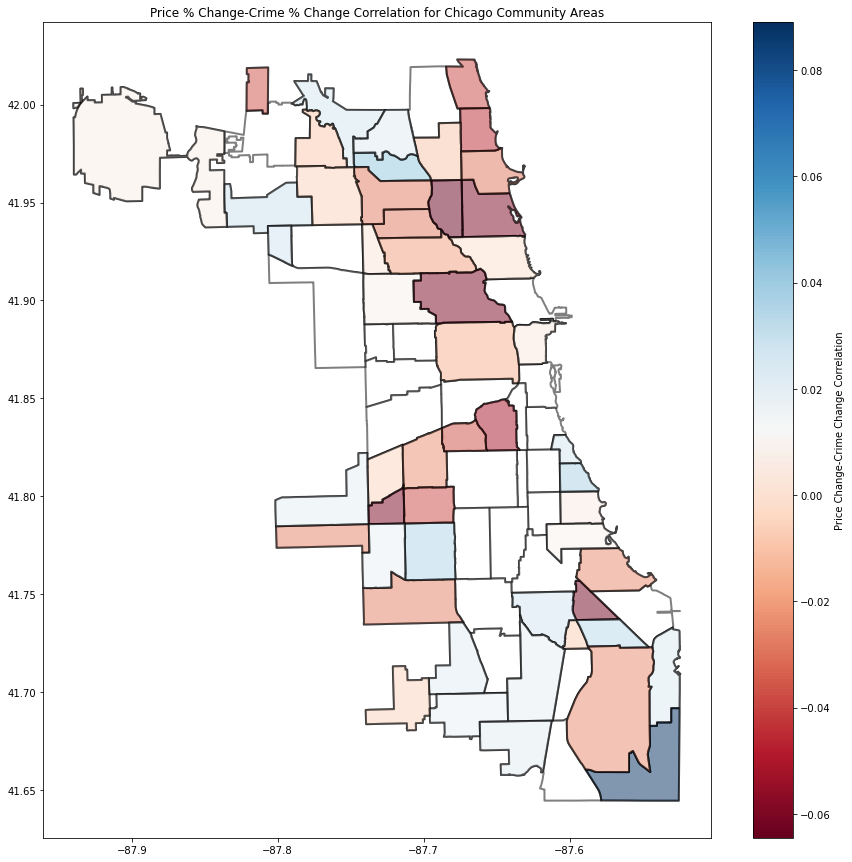

In [133]:
get_graph_corr_change()

Given weak correlation level in general, the geo pattern of the correlation between monthly price percentage change and the monthly crime percentage change (no lag) is the most similar to the geo pattern we observe from the price-crime rate correlation analysis. A one percent decrease in criminal activities tends to correspond to a more significant price percentage increase for community areas with higher housing prices in the northern part of Chicago.